<a href="https://colab.research.google.com/github/abomhold/Catagorical-Regression-Analysis/blob/master/regression_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook details the comparision between decision tree regression, and the KNN regression of the tree trunk temperature modeling problem.

Assume $Y=f(\mathbf{X})+\epsilon$

Here $Y:$ response

(temperature in tree trunk)

$\mathbf{X}=[X_1, ..., X_n]:$ features, or predictors

(weather condition)

$\epsilon:$ random error term (independent of $\mathbf{X}$)

## Data explanation
We model the temperature of a tree trunk using various regression methods, based on weather conditions and measurements of the bark and core of the tree trunks.

We use data collected onsite in Brazil, over a 7 day period, in August of 2022. These data include weather data, as well as temperature data consisting of core and bark temperatures, with two mid-trunk temperatures as validation for our model.

We used a developed wireless sensor device that can measure temperature in 10 different position (direction and height) around the tree trunk and 3 different depths. Two spreadsheets were populated with 1 week long of data both from the tree and from our weather station in Brazil.

The Tree Data Spreadsheet has the following notation:

1. DXX@YY, where D = direction (N = North, S = South, E = East, W =West), XX = depth of the temperature sensor from the tree core, and YY = height of the temperature sensor. For example: S4.5cm@1m = sensor to the South 4.5 cm depth at 1 m height.
2. Only the external sensor has a different notation, namely W\_Ext\_Temp\@ 3.5m = to the West at 3.5 m height.

The weather station (Modelo D140193 of Ammonit Measurement GmbH) is located near the tree. The weather station Spreadsheet has the following parameters:

  1. ``Anemometer;win\_speed;Avg (m/s)'': Average wind speed in m/s measured by a anemometer
  2. ``Wind Vane TMR;wind\_direction;Avg ($^{\circ}$)'': Average wind direction in $^{\circ}$ measured by a Wind Vane
  3. ``Hygro/Thermo;humidity;Avg (\%)'': Average  humidity in \% measured by a Hygrometer
  4. ``Hygro/Thermo;temperature;Avg ($^{\circ}$C)'': Average temperature in $^{\circ}$C measured by a Hygrometer
  5. ``Barometer;air\_pressure;Avg (hPa)'': Average air pressure in hPa   measured by a Barometer
  6. ``DNI (Direct Normal Irradiance) Pyrheliometer;solar\_DNI;Avg (W/m$^2$)'':  Average Direct Normal Irradiance in W/m$^2$ measured by a Pyrheliometer.

The Direct Normal Irradiance (DNI) is a measurement of the Solar Irradiance. The Global Irradiance is the sum of the DNI and the Diffuse Irradiance. DNI is a fraction of the global solar irradiation, and is the most important parameter in a solar plant installation. So, we use of DNI to measure solar radiation in this model.

Weather data is collected every 10 minutes, starting at 00:00; temperature data is collected every 3 minutes, starting at 00:01. It is reasonable to assume weather parameters and tree temperatures are continuous functions of time, so we linearly interpret the collected data to obtain measurements of the same length for our regression analysis.

The radius of the mango tree is $r = 0.135$ m, and consider a 24 hour period. We use $n_t$ to denote time steps over time, and $n_x$ grid points in space, and these are parameters used in the linear interpolation of temperature and weather data.

In [665]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import sys
print("Python 3 version is", sys.version)
import matplotlib
print("Matplotlib version is", matplotlib.__version__)
print("Numpy version is", np.__version__)
print("Pandas version is", pd.__version__)

Python 3 version is 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
Matplotlib version is 3.10.0
Numpy version is 1.26.4
Pandas version is 2.2.2


In [666]:
# from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, IsolationForest

from sklearn.metrics import mean_squared_error, mean_absolute_error
# from sklearn import preprocessing
import sklearn
print("scikit learn version is", sklearn. __version__)

scikit learn version is 1.6.1


In [667]:
# define parameter
n_t = 450
radius = 0.135 # unit m
time = np.linspace(0, 24, n_t, endpoint = False)

In [668]:
# # for binder's jupyterlab
# !pip3 install openpyxl

In [669]:
colnames = ['temp_datetime', 's45_1', 'e9_1', 'n135_1','e45_2', 'n9_2', 'w135_2', 'n45_3', 'w9_3','s135_3', 'w_ext_35']
url1 = "https://raw.githubusercontent.com/yajuna/linearRegression/master/Tree_Temp_Values_AUG21_to_AUG28_2022.xlsx"
dataTemp = pd.read_excel(url1,names=colnames)
dataTemp['temp_datetime'] = pd.to_datetime(dataTemp['temp_datetime'])
dataTemp = dataTemp.set_index('temp_datetime')

In [670]:
train_range = dataTemp.loc['2022-08-21':'2022-08-21 23:59:59']

test_range = dataTemp.loc['2022-08-22':'2022-08-22 23:59:59']

train_temp_size = len(train_range.index)
# linear interpolate the measured temperature
train_coreTemp = np. interp(time, np.linspace(0,24,train_temp_size),train_range.s135_3)
train_midTemp1 = np. interp(time, np.linspace(0,24,train_temp_size),train_range.w9_3)
train_midTemp2 = np. interp(time, np.linspace(0,24,train_temp_size),train_range.n45_3)
train_barkTemp = np. interp(time, np.linspace(0,24,train_temp_size),train_range.w_ext_35)

test_temp_size = len(test_range.index)
test_coreTemp = np. interp(time, np.linspace(0,24,test_temp_size),test_range.s135_3)
test_midTemp1 = np. interp(time, np.linspace(0,24,test_temp_size),test_range.w9_3)
test_midTemp2 = np. interp(time, np.linspace(0,24,test_temp_size),test_range.n45_3)
test_barkTemp = np. interp(time, np.linspace(0,24,test_temp_size),test_range.w_ext_35)

print("measured temperature data read")
print(train_range)

print(test_range)

measured temperature data read
                     s45_1   e9_1  n135_1  e45_2   n9_2  w135_2  n45_3   w9_3  \
temp_datetime                                                                   
2022-08-21 00:01:51  25.18  26.25   24.62  25.62  26.12   26.00  25.25  26.00   
2022-08-21 00:05:07  25.18  26.18   24.62  25.68  26.12   26.00  25.25  26.00   
2022-08-21 00:08:23  25.12  26.18   24.62  25.62  26.12   26.00  25.18  25.93   
2022-08-21 00:11:38  25.18  26.18   24.56  25.62  26.06   26.00  25.18  26.00   
2022-08-21 00:14:54  25.12  26.18   24.62  25.62  26.06   26.00  25.18  26.00   
...                    ...    ...     ...    ...    ...     ...    ...    ...   
2022-08-21 23:46:08  25.18  26.43   25.06  25.87  26.68   26.56  25.56  26.37   
2022-08-21 23:49:24  25.18  26.43   25.06  25.87  26.68   26.56  25.56  26.37   
2022-08-21 23:52:40  25.18  26.43   25.06  25.87  26.68   26.56  25.50  26.37   
2022-08-21 23:55:56  25.12  26.43   25.00  25.87  26.62   26.50  25.50  26.37 

In [671]:
colnames = ['weather_datetime', 'wind_speed', 'wind_direction', 'humidity', 'air_temperature', 'air_pressure', 'solar_DNI']
url2 = "https://raw.githubusercontent.com/yajuna/linearRegression/master/Weather_Station_AUG21_to_AUG28_2022.xlsx"
dataWeather = pd.read_excel(url2,names=colnames)
dataWeather['weather_datetime'] = pd.to_datetime(dataWeather['weather_datetime'])
dataWeather = dataWeather.set_index('weather_datetime')

In [672]:
train_weather = dataWeather.loc['2022-08-21':'2022-08-21 23:59:59']

test_weather = dataWeather.loc['2022-08-22':'2022-08-22 23:59:59']

train_weather_size = len(train_weather.index)

train_airTemp = np.interp(time, np.linspace(0,24,train_weather_size),train_weather.air_temperature)
train_windSpeed = np.interp(time, np.linspace(0,24,train_weather_size),train_weather.wind_speed)
train_solar = np.interp(time, np.linspace(0,24,train_weather_size),train_weather.solar_DNI)
train_humidity = np.interp(time, np.linspace(0,24,train_weather_size),train_weather.humidity)
train_airPressure = np.interp(time, np.linspace(0,24,train_weather_size),train_weather.air_pressure)

test_weather_size = len(test_weather.index)

test_airTemp = np.interp(time, np.linspace(0,24,test_weather_size),test_weather.air_temperature)
test_windSpeed = np.interp(time, np.linspace(0,24,test_weather_size),test_weather.wind_speed)
test_solar = np.interp(time, np.linspace(0,24,test_weather_size),test_weather.solar_DNI)
test_humidity = np.interp(time, np.linspace(0,24,test_weather_size),test_weather.humidity)
test_airPressure = np.interp(time, np.linspace(0,24,test_weather_size),test_weather.air_pressure)

print(train_weather)

print(test_weather)

                     wind_speed  wind_direction  humidity  air_temperature  \
weather_datetime                                                             
2022-08-21 00:00:00      2.1758        195.8894   73.0005          23.8425   
2022-08-21 00:10:00      2.0381        195.6512   73.2226          23.5854   
2022-08-21 00:20:00      1.7478        193.6007   73.5104          23.3592   
2022-08-21 00:30:00      1.6064        188.9758   73.7139          23.1699   
2022-08-21 00:40:00      1.3614        199.9231   73.9565          22.9508   
...                         ...             ...       ...              ...   
2022-08-21 23:10:00      1.0138        213.2707   87.4109          22.7085   
2022-08-21 23:20:00      1.4568        205.0766   87.7499          22.6212   
2022-08-21 23:30:00      1.5097        197.3073   88.0380          22.6066   
2022-08-21 23:40:00      1.5505        194.7728   88.2570          22.6291   
2022-08-21 23:50:00      2.1849        191.2897   88.4429       

## Prepare training and testing data

The training data is collected on August 21, and the testing data is collected on August 22, as well as August 26

In [673]:
from re import X
from sklearn.preprocessing import Normalizer
#include depth as training variable
# n = 0 for 9cm; n = 1 for 4.5cm
n = 1
depth_list = [0.09/radius, 0.045/radius]

# training Y temp
Ytrain_list = [train_midTemp1, train_midTemp2]

Ytest_list = [test_midTemp1, test_midTemp2]

# depth for training is depth1 or depth2
depth = np.ones(train_coreTemp.shape) * depth_list[n]

# Training data in x; training data in y
Xtrain = [1./train_humidity, train_airTemp, train_windSpeed, train_solar, depth, train_coreTemp, train_barkTemp]

X_train = np.array(Xtrain).T
Y_train = Ytrain_list[n]

# testing data in x, testing data in y.
ic_test = np.ones(test_coreTemp.shape) * Ytest_list[n][0]
Xtest = [1./test_humidity, test_airTemp, test_windSpeed, test_solar, depth, test_coreTemp, test_barkTemp]
X_test = np.array(Xtest).T
Y_test = Ytest_list[n]

print(X_train)
print(Y_train)
print(X_test)
print(Y_test)

[[1.36985363e-02 2.38425000e+01 2.17580000e+00 ... 3.33333333e-01
  2.58100000e+01 2.39300000e+01]
 [1.36853051e-02 2.37607993e+01 2.13204200e+00 ... 3.33333333e-01
  2.58100000e+01 2.38196000e+01]
 [1.36720994e-02 2.36790987e+01 2.08828400e+00 ... 3.33333333e-01
  2.58100000e+01 2.37596000e+01]
 ...
 [1.13294324e-02 2.26316340e+01 1.58010533e+00 ... 3.33333333e-01
  2.60600000e+01 2.29468000e+01]
 [1.13218548e-02 2.26488893e+01 1.78170356e+00 ... 3.33333333e-01
  2.60600000e+01 2.30000000e+01]
 [1.13142874e-02 2.26661447e+01 1.98330178e+00 ... 3.33333333e-01
  2.60600000e+01 2.30000000e+01]]
[25.25   25.25   25.1912 25.18   25.18   25.18   25.18   25.1536 25.12
 25.12   25.12   25.1128 25.06   25.06   25.06   25.06   25.0168 25.
 25.     25.     24.972  24.93   24.93   24.93   24.9252 24.87   24.87
 24.87   24.87   24.8292 24.81   24.81   24.7836 24.75   24.75   24.75
 24.7416 24.68   24.68   24.68   24.68   24.6368 24.62   24.62   24.5912
 24.56   24.56   24.5456 24.5    24.5    24.5

In [674]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, IsolationForest
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils import check_random_state

class CustomEntropyDT(BaseEstimator, RegressorMixin):
    def __init__(self, max_depth=None, min_samples_split=2, random_state=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.random_state = random_state

    def fit(self, X, y):
        # Validate the inputs
        X, y = check_X_y(X, y)

        # Store the random state
        self.random_state = check_random_state(self.random_state)

        # Build the decision tree
        self.tree_ = self._build_tree(X, y)
        return self

    def predict(self, X):
        # Check if fit has been called
        check_is_fitted(self)

        # Validate the input
        X = check_array(X)

        # Predict class labels for each sample
        return np.array([self._predict_one(sample) for sample in X])

    def _build_tree(self, X, y, depth=0):
        # Stop conditions: max depth or min samples split
        if len(y) < self.min_samples_split or (self.max_depth and depth >= self.max_depth):
            return {'value': np.mean(y)}

        # Get the best split using custom entropy
        best_split = self._best_split(X, y)

        if best_split is None:
            return {'value': np.mean(y)}

        left_tree = self._build_tree(*best_split['left'], depth + 1)
        right_tree = self._build_tree(*best_split['right'], depth + 1)

        return {
            'feature_index': best_split['feature_index'],
            'threshold': best_split['threshold'],
            'left': left_tree,
            'right': right_tree
        }

    def _best_split(self, X, y):
        best_gain = -float('inf')
        best_split = None
        n_samples, n_features = X.shape

        for feature_index in range(n_features):
            thresholds = np.unique(X[:, feature_index])
            for threshold in thresholds:
                left_mask = X[:, feature_index] <= threshold
                right_mask = ~left_mask
                left_y, right_y = y[left_mask], y[right_mask]

                if len(left_y) < self.min_samples_split or len(right_y) < self.min_samples_split:
                    continue

                # Compute the information gain
                gain = self._differential_entropy_reduction(y, left_y, right_y)
                if gain > best_gain:
                    best_gain = gain
                    best_split = {
                        'feature_index': feature_index,
                        'threshold': threshold,
                        'left': (X[left_mask], left_y),
                        'right': (X[right_mask], right_y)
                    }

        return best_split


    def _differential_entropy_reduction(self, parent_y, left_y, right_y):
        # Differential entropy reduction
        def differential_entropy(y):
            if len(y) == 0:
                return 0
            variance = np.var(y)
            if variance == 0:
                return 0
            return 0.5 * np.log(2 * np.pi * np.e * variance)

        parent_entropy = differential_entropy(parent_y)
        left_entropy = differential_entropy(left_y)
        right_entropy = differential_entropy(right_y)

        weighted_avg_child_entropy = (len(left_y) / len(parent_y)) * left_entropy + (len(right_y) / len(parent_y)) * right_entropy

        return parent_entropy - weighted_avg_child_entropy

    def _variance_reduction(self, parent_y, left_y, right_y):
        # Variance reduction for regression
        parent_variance = np.var(parent_y)
        left_variance = np.var(left_y)
        right_variance = np.var(right_y)

        weighted_avg_child_variance = (len(left_y) / len(parent_y)) * left_variance + (len(right_y) / len(parent_y)) * right_variance

        return parent_variance - weighted_avg_child_variance

    def _predict_one(self, sample):
        # Traverse the tree to make a prediction for a single sample
        node = self.tree_
        while 'value' not in node:
            if sample[node['feature_index']] <= node['threshold']:
                node = node['left']
            else:
                node = node['right']
        return node['value']

In [675]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils import check_random_state
from sklearn.utils import resample
from sklearn.tree import DecisionTreeRegressor

class CustomExtraTreesRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=2,
                 random_state=None, criterion='squared_error', bootstrap=False,
                 max_features=1.0):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.random_state = random_state
        self.criterion = criterion
        self.bootstrap = bootstrap
        self.max_features = max_features
        self.estimators_ = []

    def fit(self, X, y):
        # Input validation
        X, y = check_X_y(X, y)
        self.random_state_ = check_random_state(self.random_state)

        # Calculate max_features
        n_features = X.shape[1]
        if isinstance(self.max_features, float):
            self.max_features_ = max(1, int(self.max_features * n_features))
        elif isinstance(self.max_features, int):
            self.max_features_ = self.max_features
        elif self.max_features == "sqrt":
            self.max_features_ = max(1, int(np.sqrt(n_features)))
        elif self.max_features == "log2":
            self.max_features_ = max(1, int(np.log2(n_features)))
        else:
            self.max_features_ = n_features

        self.estimators_ = []
        for i in range(self.n_estimators):
            # Initialize tree with splitter='random' for Extra Trees behavior
            tree = DecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                random_state=self.random_state_.randint(0, 100000),
                criterion=self.criterion,
                splitter='random',  # Key difference for Extra Trees
                max_features=self.max_features_
            )

            if self.bootstrap:
                # Optional bootstrapping (not default for Extra Trees)
                X_sample, y_sample = resample(X, y,
                    random_state=self.random_state_.randint(0, 100000))
            else:
                # Use full dataset (default for Extra Trees)
                X_sample, y_sample = X, y

            tree.fit(X_sample, y_sample)
            self.estimators_.append(tree)

        return self

    def predict(self, X):
        # Check if model has been fitted
        check_is_fitted(self)
        X = check_array(X)

        # Get predictions from all trees and average them
        predictions = np.array([tree.predict(X) for tree in self.estimators_])
        return np.mean(predictions, axis=0)

    def score(self, X, y):
        """Returns the coefficient of determination R^2 of the prediction."""
        from sklearn.metrics import r2_score
        return r2_score(y, self.predict(X))

## In the following, we look at regression with the K nearest neighbors (KNN) as well as Decision trees.

Both methods are implemented in Python, with the `scikit learn` library.

## The following two cells are for decision tree regression

In [676]:
# Fit regression model with random forest
rf_regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
rf_regressor.fit(X_train, Y_train)
# Fit regression model with random forest
ex_rf_regressor = ExtraTreesRegressor(n_estimators = 100, random_state = 0)
ex_rf_regressor.fit(X_train, Y_train)
# Fit regression model with random forest
gb_rf_regressor = GradientBoostingRegressor(n_estimators = 100, random_state = 0)
gb_rf_regressor.fit(X_train, Y_train)
# Fit regression model with random forest
ab_rf_regressor = AdaBoostRegressor(n_estimators = 100, random_state = 0)
ab_rf_regressor.fit(X_train, Y_train)
# Fit regression model with random forest
br_rf_regressor = BaggingRegressor(n_estimators = 100, random_state = 0)
br_rf_regressor.fit(X_train, Y_train)
# Fit regression model with random forest
is_rf_regressor = IsolationForest(n_estimators = 100, random_state = 0)
is_rf_regressor.fit(X_train, Y_train)

# Fit custom ensamble method
custom_ex_rf_regressor = CustomExtraTreesRegressor(n_estimators = 100, random_state = 0)
custom_ex_rf_regressor.fit(X_train, Y_train)

y_2 = rf_regressor.predict(X_test)
y_3 = ex_rf_regressor.predict(X_test)
y_4 = gb_rf_regressor.predict(X_test)
y_5 = ab_rf_regressor.predict(X_test)
y_6 = br_rf_regressor.predict(X_test)
y_7 = is_rf_regressor.predict(X_test)
y_custom_ex = custom_ex_rf_regressor.predict(X_test)

Squared_error
Absolute error is 3.1873777777777796 , Relative error is 0.11752867912159955
Mean absolute error is 0.7912220046547338 , Mean relative error is 0.030807734798177798
Median absolute error is 0.5469272727272703 , Median relative error is 0.022498036722635555

MSE
Absolute error is 3.1873777777777796 , Relative error is 0.11752867912159955
Mean absolute error is 0.7912220046547338 , Mean relative error is 0.030807734798177798
Median absolute error is 0.5469272727272703 , Median relative error is 0.022498036722635555

Absolute_error
Absolute error is 3.3100000000000023 , Relative error is 0.12205014749262545
Mean absolute error is 0.8279445432098768 , Mean relative error is 0.03208378198435019
Median absolute error is 0.379999999999999 , Median relative error is 0.01579384871155441

Poisson
Absolute error is 3.282577777777778 , Relative error is 0.1210390036053753
Mean absolute error is 0.7625634722329172 , Mean relative error is 0.029540113438397436
Median absolute error is 

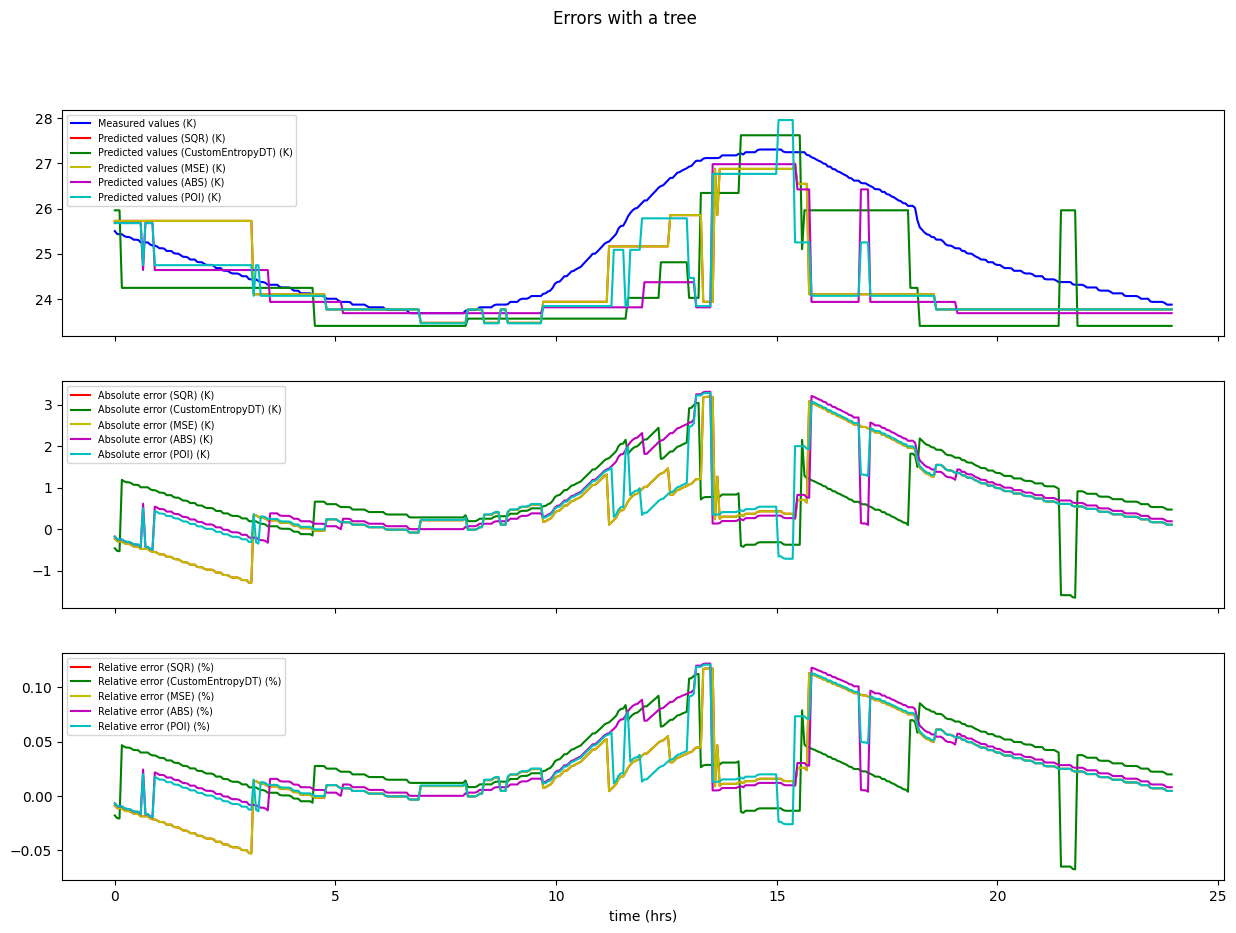

In [677]:
# prediction with the above regression models
# Fit regression model with decision tree
dt_regressor_sqr = DecisionTreeRegressor(criterion='squared_error',max_depth=4,random_state=0)
dt_regressor_sqr.fit(X_train, Y_train)
dt_regressor_mse = DecisionTreeRegressor(criterion='friedman_mse',max_depth=4,random_state=0)
dt_regressor_mse.fit(X_train, Y_train)
dt_regressor_abs = DecisionTreeRegressor(criterion='absolute_error',max_depth=4, random_state=0)
dt_regressor_abs.fit(X_train, Y_train)
dt_regressor_poi = DecisionTreeRegressor(criterion='poisson',max_depth=4, random_state=0)
dt_regressor_poi.fit(X_train, Y_train)
# Fit regression model with custom tree
custom_dt_regressor = CustomEntropyDT(max_depth=4, random_state=0)
custom_dt_regressor.fit(X_train, Y_train)
y_custom = custom_dt_regressor.predict(X_test)

y_1 = dt_regressor_sqr.predict(X_test)
y_1_mse = dt_regressor_mse.predict(X_test)
y_1_abs = dt_regressor_abs.predict(X_test)
y_1_poi = dt_regressor_poi.predict(X_test)
y_custom = custom_dt_regressor.predict(X_test)
y_list = [y_1, y_1_mse, y_1_abs, y_1_poi, y_custom]
y_name = ['Squared_error', 'MSE', 'Absolute_error', 'Poisson', 'Custom']

for i in range(len(y_list)):
  print(y_name[i])
  print("Absolute error is", np.max(np.abs(Y_test - y_list[i])), ", Relative error is", np.max(np.abs((Y_test - y_list[i])/Y_test)))
  print("Mean absolute error is", np.mean(np.abs(Y_test - y_list[i])), ", Mean relative error is", np.mean(np.abs((Y_test - y_list[i])/Y_test)))
  print("Median absolute error is", np.median(np.abs(Y_test - y_list[i])), ", Median relative error is", np.median(np.abs((Y_test - y_list[i])/Y_test)))
  print()



fig0, axs = plt.subplots(3, sharex=True, sharey=False)
fig0.suptitle('Errors with a tree')
# Fix the plot size by specifying the figsize directly
fig0.set_size_inches(15,10)  # Set the size as needed (e.g., 10 inches width by 12 inches height)
axs[0].plot(time, Y_test, 'b-', label='Measured values (K)')
axs[0].plot(time, y_1, 'r-', label='Predicted values (SQR) (K)')
axs[0].plot(time, y_custom, 'g-', label='Predicted values (CustomEntropyDT) (K)')
axs[0].plot(time, y_1_mse, 'y-', label='Predicted values (MSE) (K)')
axs[0].plot(time, y_1_abs, 'm-', label='Predicted values (ABS) (K)')
axs[0].plot(time, y_1_poi, 'c-', label='Predicted values (POI) (K)')
axs[0].legend(loc='upper left', fontsize='x-small')
axs[1].plot(time, Y_test - y_1, 'r-', label='Absolute error (SQR) (K)')
axs[1].plot(time, Y_test - y_custom, 'g-', label='Absolute error (CustomEntropyDT) (K)')
axs[1].plot(time, Y_test - y_1_mse, 'y-', label='Absolute error (MSE) (K)')
axs[1].plot(time, Y_test - y_1_abs, 'm-', label='Absolute error (ABS) (K)')
axs[1].plot(time, Y_test - y_1_poi, 'c-', label='Absolute error (POI) (K)')
axs[1].legend(loc='upper left', fontsize='x-small')
axs[2].plot(time, (Y_test - y_1) / Y_test, 'r-', label='Relative error (SQR) (%)')
axs[2].plot(time, (Y_test - y_custom) / Y_test, 'g-', label='Relative error (CustomEntropyDT) (%)')
axs[2].plot(time, (Y_test - y_1_mse) / Y_test, 'y-', label='Relative error (MSE) (%)')
axs[2].plot(time, (Y_test - y_1_abs) / Y_test, 'm-', label='Relative error (ABS) (%)')
axs[2].plot(time, (Y_test - y_1_poi) / Y_test, 'c-', label='Relative error (POI) (%)')
axs[2].legend(loc='upper left', fontsize='x-small')


plt.xlabel('time (hrs)', fontsize=10)
plt.show()

In [654]:
feature_names = ['humidity', 'air_temperature', 'wind_speed', 'solar_DNI', 'depth', 'core_temperature', 'bark_temperature']
models = [dt_regressor_sqr, dt_regressor_mse, dt_regressor_abs, dt_regressor_poi]
y_list = [y_1, y_1_mse, y_1_abs, y_1_poi]
y_name = ['Squared_error', 'MSE', 'Absolute_error', 'Poisson']


# Model Accuaracy and Importance
for i in range(len(y_list)):
  importances = models[i].feature_importances_
  indices = np.argsort(importances)[::-1]
  print("\n%s" % (y_name[i]))
  print("Absolute error is", np.max(np.abs(Y_test - y_list[i])), ", Mean absolute error is", np.mean(np.abs(Y_test - y_list[i])), ", Median absolute error is", np.median(np.abs(Y_test - y_list[i])))
  print("Relative error is", np.max(np.abs((Y_test - y_list[i])/Y_test)), ", Mean relative error is", np.mean(np.abs((Y_test - y_list[i])/Y_test)), ", Median relative error is", np.median(np.abs((Y_test - y_list[i])/Y_test)))
  print("Traditional Importance Feature ranking:")
  for f in range(X_train.shape[1]):
      print("\t%d. feature %s (%f)" % (f + 1, feature_names[indices[f]], importances[indices[f]]))
  result = permutation_importance(models[i], X_test, Y_test, n_repeats=100, random_state=0)
  importances = result.importances_mean
  indices = np.argsort(importances)[::-1]
  print("Permutation Importance Feature ranking:")
  for f in range(X_train.shape[1]):
      print("\t%d. feature %s (%f)" % (f + 1, feature_names[indices[f]], importances[indices[f]]))

# custom model accuacy and importance
print("\n%s" % ('CustomEntropyDT'))
print("Absolute error is", np.max(np.abs(Y_test - y_custom)), ", Mean absolute error is", np.mean(np.abs(Y_test - y_custom)), ", Median absolute error is", np.median(np.abs(Y_test - y_custom)))
print("Relative error is", np.max(np.abs((Y_test - y_custom)/Y_test)), ", Mean relative error is", np.mean(np.abs((Y_test - y_custom)/Y_test)), ", Median relative error is", np.median(np.abs((Y_test - y_custom)/Y_test)))
result = permutation_importance(custom_dt_regressor, X_test, Y_test, n_repeats=100, random_state=0)
importances = result.importances_mean
indices = np.argsort(importances)[::-1]
print("Permutation Importance Feature ranking:")
for f in range(X_train.shape[1]):
    print("\t%d. feature %s (%f)" % (f + 1, feature_names[indices[f]], importances[indices[f]]))



Squared_error
Absolute error is 3.1873777777777796 , Mean absolute error is 0.7912220046547338 , Median absolute error is 0.5469272727272703
Relative error is 0.11752867912159955 , Mean relative error is 0.030807734798177798 , Median relative error is 0.022498036722635555
Traditional Importance Feature ranking:
	1. feature core_temperature (0.473301)
	2. feature bark_temperature (0.473177)
	3. feature air_temperature (0.027000)
	4. feature humidity (0.025382)
	5. feature solar_DNI (0.001139)
	6. feature depth (0.000000)
	7. feature wind_speed (0.000000)
Permutation Importance Feature ranking:
	1. feature bark_temperature (1.285035)
	2. feature core_temperature (0.643623)
	3. feature air_temperature (0.045057)
	4. feature solar_DNI (0.029911)
	5. feature depth (0.000000)
	6. feature wind_speed (0.000000)
	7. feature humidity (-0.033291)

MSE
Absolute error is 3.1873777777777796 , Mean absolute error is 0.7912220046547338 , Median absolute error is 0.5469272727272703
Relative error is 0

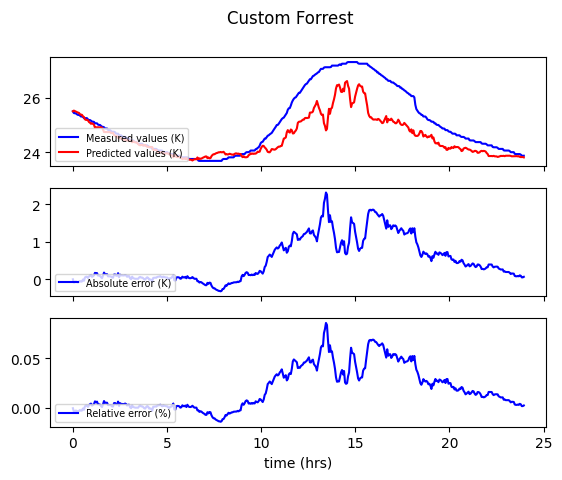


Custom ET Forest
Absolute error is 2.320300000000021 , Mean absolute error is 0.5509707703703803 , Median absolute error is 0.32361200000002555
Relative error is 0.08555678466076773 , Mean relative error is 0.021149524240054084 , Median relative error is 0.013314527027025631
Permutation Importance Feature ranking:
	1. feature core_temperature (0.551130)
	2. feature bark_temperature (0.549268)
	3. feature air_temperature (0.197521)
	4. feature humidity (0.043400)
	5. feature wind_speed (0.042227)
	6. feature solar_DNI (0.010711)
	7. feature depth (0.000000)


In [678]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics as metrics
from sklearn.inspection import permutation_importance

# visualization
fig0, axs = plt.subplots(3, sharex=True, sharey=False)
fig0.suptitle('Custom Forrest')
axs[0].plot(time, Y_test, 'b-', label='Measured values (K)')
axs[0].plot(time, y_custom_ex, 'r-', label='Predicted values (K)')
axs[1].plot(time, Y_test - y_custom_ex, 'b-', label='Absolute error (K)')
axs[2].plot(time, (Y_test - y_custom_ex)/Y_test, 'b-', label='Relative error (%)')
axs[0].legend(loc='lower left', fontsize = 'x-small')
axs[1].legend(loc='lower left', fontsize = 'x-small')
axs[2].legend(loc='lower left', fontsize = 'x-small')
plt.xlabel('time (hrs)', fontsize=10)
plt.show()

# custom model accuacy and importance
print("\n%s" % ('Custom ET Forest'))
print("Absolute error is", np.max(np.abs(Y_test - y_custom_ex)), ", Mean absolute error is", np.mean(np.abs(Y_test - y_custom_ex)), ", Median absolute error is", np.median(np.abs(Y_test - y_custom_ex)))
print("Relative error is", np.max(np.abs((Y_test - y_custom_ex)/Y_test)), ", Mean relative error is", np.mean(np.abs((Y_test - y_custom_ex)/Y_test)), ", Median relative error is", np.median(np.abs((Y_test - y_custom_ex)/Y_test)))
result = permutation_importance(custom_ex_rf_regressor, X_test, Y_test, n_repeats=10, random_state=0)
importances = result.importances_mean
indices = np.argsort(importances)[::-1]
print("Permutation Importance Feature ranking:")
for f in range(X_train.shape[1]):
    print("\t%d. feature %s (%f)" % (f + 1, feature_names[indices[f]], importances[indices[f]]))


Absolute error is 3.1873777777777796 , Relative error is 0.11752867912159955


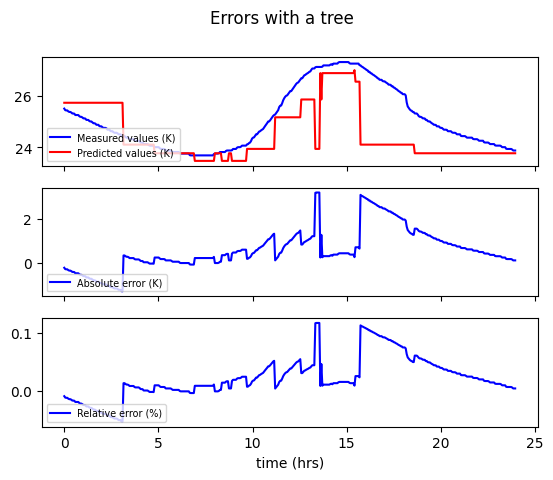

In [656]:
# visualization
print ("Absolute error is", np.max(np.abs(Y_test - y_1)), ", Relative error is", np.max(np.abs((Y_test - y_1)/Y_test)))


fig0, axs = plt.subplots(3, sharex=True, sharey=False)
fig0.suptitle('Errors with a tree')
axs[0].plot(time, Y_test, 'b-', label='Measured values (K)')
axs[0].plot(time, y_1, 'r-', label='Predicted values (K)')
axs[1].plot(time, Y_test - y_1, 'b-', label='Absolute error (K)')
axs[2].plot(time, (Y_test - y_1)/Y_test, 'b-', label='Relative error (%)')
axs[0].legend(loc='lower left', fontsize = 'x-small')
axs[1].legend(loc='lower left', fontsize = 'x-small')
axs[2].legend(loc='lower left', fontsize = 'x-small')
plt.xlabel('time (hrs)', fontsize=10)
# fig0.savefig("shallow_decisionTree.eps")
plt.show()

Absolute error is 2.6163000000000167 , Relative error is 0.09668514412416913


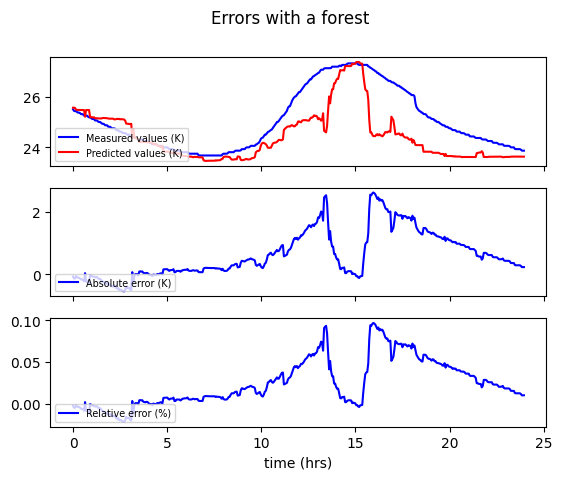

In [657]:
# visualization
print ("Absolute error is", np.max(np.abs(Y_test - y_2)), ", Relative error is", np.max(np.abs((Y_test - y_2)/Y_test)))


fig, axs = plt.subplots(3, sharex=True, sharey=False)
fig.suptitle('Errors with a forest')
axs[0].plot(time, Y_test, 'b-', label='Measured values (K)')

axs[0].plot(time, y_2, 'r-', label='Predicted values (K)')
axs[1].plot(time, Y_test - y_2, 'b-', label='Absolute error (K)')
axs[2].plot(time, (Y_test - y_2)/Y_test, 'b-', label='Relative error (%)')
axs[0].legend(loc='lower left', fontsize = 'x-small')
axs[1].legend(loc='lower left', fontsize = 'x-small')
axs[2].legend(loc='lower left', fontsize = 'x-small')
plt.xlabel('time (hrs)', fontsize=10)
# fig.savefig("deep_decisionTree.eps")
plt.show()

Absolute error is 2.457808000000014 , Relative error is 0.09062713864306837


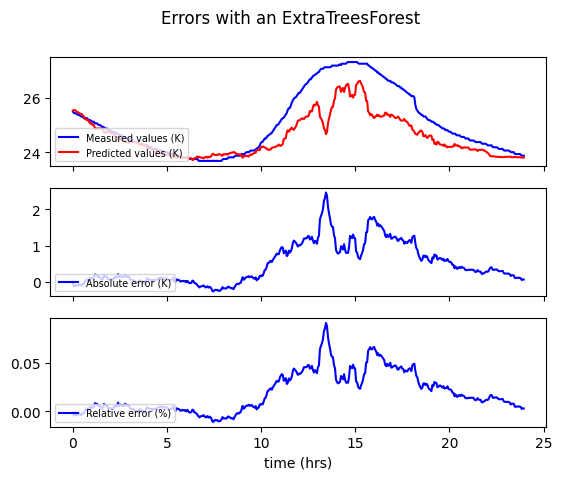

In [658]:
# visualization
print ("Absolute error is", np.max(np.abs(Y_test - y_3)), ", Relative error is", np.max(np.abs((Y_test - y_3)/Y_test)))


fig, axs = plt.subplots(3, sharex=True, sharey=False)
fig.suptitle('Errors with an ExtraTreesForest')
axs[0].plot(time, Y_test, 'b-', label='Measured values (K)')

axs[0].plot(time, y_3, 'r-', label='Predicted values (K)')
axs[1].plot(time, Y_test - y_3, 'b-', label='Absolute error (K)')
axs[2].plot(time, (Y_test - y_3)/Y_test, 'b-', label='Relative error (%)')
axs[0].legend(loc='lower left', fontsize = 'x-small')
axs[1].legend(loc='lower left', fontsize = 'x-small')
axs[2].legend(loc='lower left', fontsize = 'x-small')
plt.xlabel('time (hrs)', fontsize=10)
# fig.savefig("deep_decisionTree.eps")
plt.show()

Absolute error is 3.0291128867122374 , Relative error is 0.11161612778982892


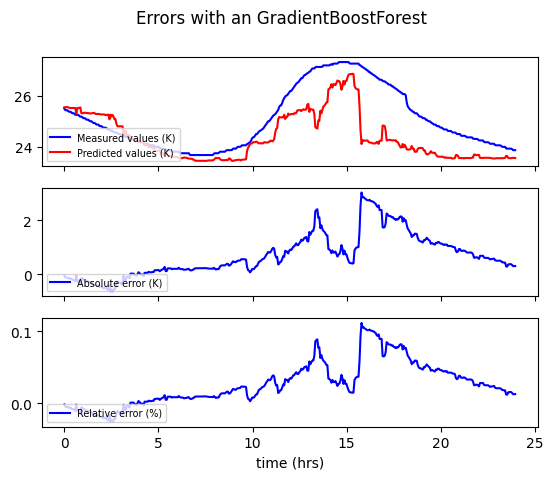

In [659]:
# visualization
print ("Absolute error is", np.max(np.abs(Y_test - y_4)), ", Relative error is", np.max(np.abs((Y_test - y_4)/Y_test)))


fig, axs = plt.subplots(3, sharex=True, sharey=False)
fig.suptitle('Errors with an GradientBoostForest')
axs[0].plot(time, Y_test, 'b-', label='Measured values (K)')

axs[0].plot(time, y_4, 'r-', label='Predicted values (K)')
axs[1].plot(time, Y_test - y_4, 'b-', label='Absolute error (K)')
axs[2].plot(time, (Y_test - y_4)/Y_test, 'b-', label='Relative error (%)')
axs[0].legend(loc='lower left', fontsize = 'x-small')
axs[1].legend(loc='lower left', fontsize = 'x-small')
axs[2].legend(loc='lower left', fontsize = 'x-small')
plt.xlabel('time (hrs)', fontsize=10)
# fig.savefig("deep_decisionTree.eps")
plt.show()

Absolute error is 3.0570400000000006 , Relative error is 0.11247387785136131


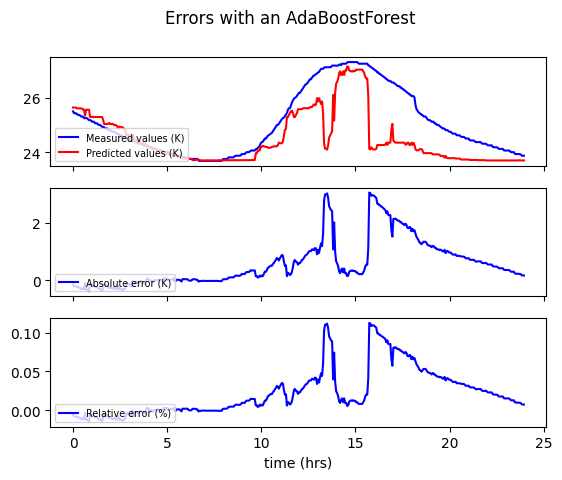

In [660]:
# visualization
print ("Absolute error is", np.max(np.abs(Y_test - y_5)), ", Relative error is", np.max(np.abs((Y_test - y_5)/Y_test)))


fig, axs = plt.subplots(3, sharex=True, sharey=False)
fig.suptitle('Errors with an AdaBoostForest')
axs[0].plot(time, Y_test, 'b-', label='Measured values (K)')

axs[0].plot(time, y_5, 'r-', label='Predicted values (K)')
axs[1].plot(time, Y_test - y_5, 'b-', label='Absolute error (K)')
axs[2].plot(time, (Y_test - y_5)/Y_test, 'b-', label='Relative error (%)')
axs[0].legend(loc='lower left', fontsize = 'x-small')
axs[1].legend(loc='lower left', fontsize = 'x-small')
axs[2].legend(loc='lower left', fontsize = 'x-small')
plt.xlabel('time (hrs)', fontsize=10)
# fig.savefig("deep_decisionTree.eps")
plt.show()

Absolute error is 2.6211880000000036 , Relative error is 0.09686577974870672


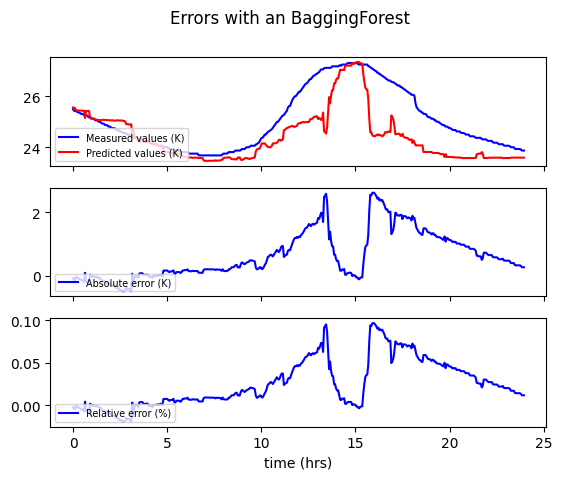

In [661]:
# visualization
print ("Absolute error is", np.max(np.abs(Y_test - y_6)), ", Relative error is", np.max(np.abs((Y_test - y_6)/Y_test)))


fig, axs = plt.subplots(3, sharex=True, sharey=False)
fig.suptitle('Errors with an BaggingForest')
axs[0].plot(time, Y_test, 'b-', label='Measured values (K)')

axs[0].plot(time, y_6, 'r-', label='Predicted values (K)')
axs[1].plot(time, Y_test - y_6, 'b-', label='Absolute error (K)')
axs[2].plot(time, (Y_test - y_6)/Y_test, 'b-', label='Relative error (%)')
axs[0].legend(loc='lower left', fontsize = 'x-small')
axs[1].legend(loc='lower left', fontsize = 'x-small')
axs[2].legend(loc='lower left', fontsize = 'x-small')
plt.xlabel('time (hrs)', fontsize=10)
# fig.savefig("deep_decisionTree.eps")
plt.show()

Absolute error is 28.31 , Relative error is 1.0422297297297298


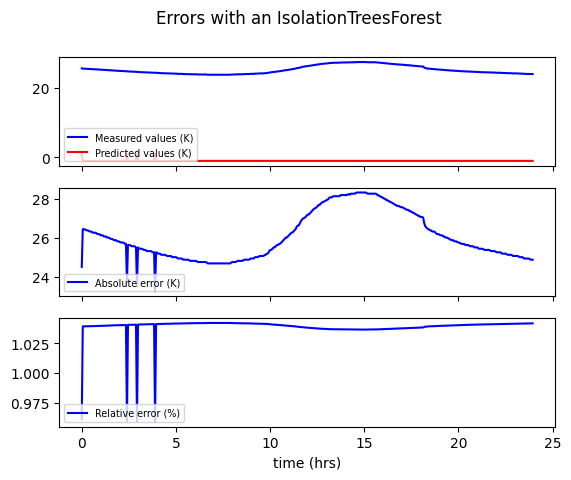

In [662]:
# visualization
print ("Absolute error is", np.max(np.abs(Y_test - y_7)), ", Relative error is", np.max(np.abs((Y_test - y_7)/Y_test)))


fig, axs = plt.subplots(3, sharex=True, sharey=False)
fig.suptitle('Errors with an IsolationTreesForest')
axs[0].plot(time, Y_test, 'b-', label='Measured values (K)')

axs[0].plot(time, y_7, 'r-', label='Predicted values (K)')
axs[1].plot(time, Y_test - y_7, 'b-', label='Absolute error (K)')
axs[2].plot(time, (Y_test - y_7)/Y_test, 'b-', label='Relative error (%)')
axs[0].legend(loc='lower left', fontsize = 'x-small')
axs[1].legend(loc='lower left', fontsize = 'x-small')
axs[2].legend(loc='lower left', fontsize = 'x-small')
plt.xlabel('time (hrs)', fontsize=10)
# fig.savefig("deep_decisionTree.eps")
plt.show()

## In the following, we look at KNN regression model
We experiment with different values of $K$ and observe bias, as well as vriance.


In [663]:
n_neighbors = 4
# weights = "uniform", "distance"

knn = KNeighborsRegressor(n_neighbors, weights="distance")
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)

Absolute error is 4.349611582407501 , Relative error is 0.18107286227828742


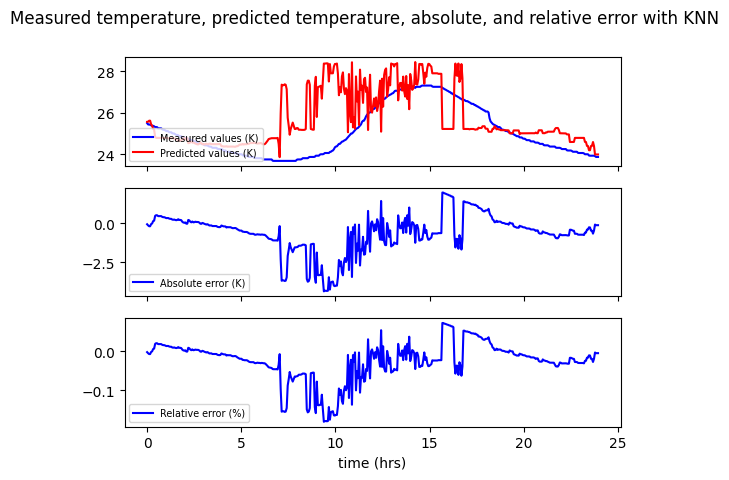

In [664]:
# visualization
print ("Absolute error is", np.max(np.abs(Y_test - Y_pred)), ", Relative error is", np.max(np.abs((Y_test - Y_pred)/Y_test)))

fig1, axs = plt.subplots(3, sharex=True, sharey=False)
fig1.suptitle('Measured temperature, predicted temperature, absolute, and relative error with KNN')
axs[0].plot(time, Y_test, 'b-', label='Measured values (K)')
axs[0].plot(time, Y_pred, 'r-', label='Predicted values (K)')
axs[1].plot(time, Y_test - Y_pred, 'b-', label='Absolute error (K)')
axs[2].plot(time, (Y_test - Y_pred)/Y_test, 'b-', label='Relative error (%)')

axs[0].legend(loc='lower left', fontsize = 'x-small')
axs[1].legend(loc='lower left', fontsize = 'x-small')
axs[2].legend(loc='lower left', fontsize = 'x-small')
plt.xlabel('time (hrs)', fontsize=10)
# fig.savefig("deep_decisionTree.eps")
plt.show()